# Kovarianz

In [3]:
# Definition der benötigten Funktionspakete

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import os

## Wir erstellen ein künstliches (quasi-analoges) Signal

In [16]:
N = 1001 # Länge des Datenvektors
t = np.linspace(0, N-1, N) # Zeitvektor von Punkten mit Abstand 1 in Einheit von Nanosekunden (als konkretes Beispiel)
# t_tot = N ns für unser Beispiel

f_sig = 0.01
Amp1 = 1.2 
Amp3 = 5.2
sig1 = Amp1*np.sin(2*np.pi*f_sig*t)
sig2 = Amp1*np.cos(2*np.pi*f_sig*t)
sig3 = Amp3*np.sin(2*np.pi*f_sig*t)
noise_amp = 0.1
noise1 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
noise2 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
noise3 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
U1 = sig1 + noise1
U2 = sig2 + noise2
U3 = sig3 + noise3

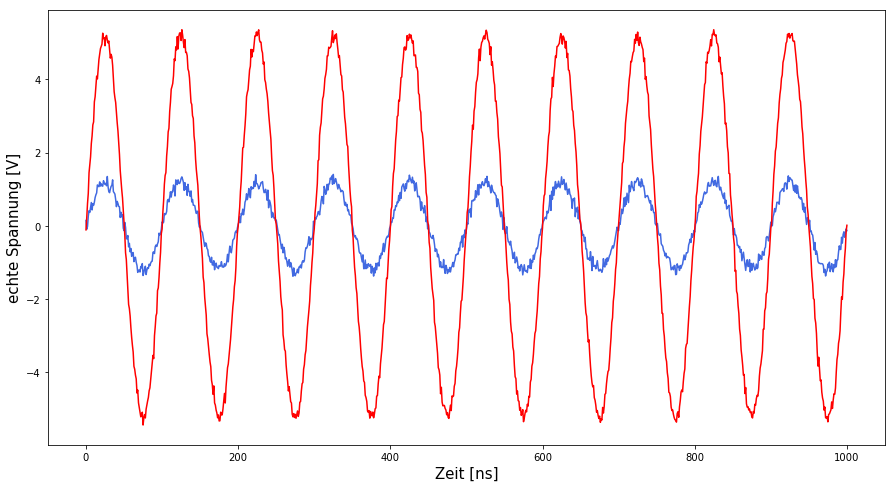

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(t, U1, color='royalblue', label="Spannung U (Ohm)")
plt.plot(t, U3, color='red', label="Spannung U (Ohm)")
plt.axes().set_aspect('auto', 'datalim')
plt.xlabel('Zeit [ns]', fontsize = 15)
plt.ylabel('echte Spannung [V]', fontsize = 15)
plt.show()

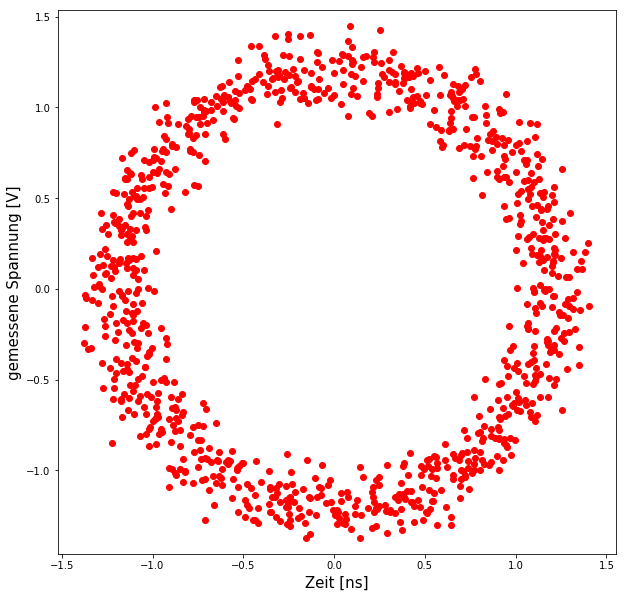

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(U1, U2, color = "red", marker='o')
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('Zeit [ns]', fontsize = 15)
plt.ylabel('gemessene Spannung [V]', fontsize = 15)
plt.show()

## Bestimmung der Kovarianz

In [22]:
C = np.stack((U1,U2), axis=0)
np.cov(C)
np.corrcoef(C)

array([[1.00000000e+00, 3.14728513e-04],
       [3.14728513e-04, 1.00000000e+00]])

## Wir "messen" unser Signal mit einem simulierten Analog-Digital-Konverter (ADC)
### Wir wählen ideale ADC-Parameter, um die "echte" Messung zu sehen, U_mess = U. Den Einfluss nicht-idealer Parameter kann man leicht selber erforschen.

In [23]:
Delta_t = 1 # zeitl. Abstand der Messpunkte in den gewählten Einheiten: für einen Zeitvektor t mit Abständen von je 1 Nanosekunde misst unser ADC einen Datenpunkt alle Delta_t Nanosekunden
U_max = 10 # maximal messbarer Wert: alle grösseren Werte werden als U_max angezeigt ("clipping")
U_min = 0.1 # minimaler messbarer Spannungsunterschied der Signalwerte: Spannungsauflösung des ADC
U_noise = 1.5 # Standardabweichung des Spannungsrauschens, das dem Signal durch den Messprozess hinzigefügt wird

# Initialisierung der Messvektoren
n_mess = math.floor(N/Delta_t)-1 # Anzahl gemesener Punkte. "floor" rundet ab
n = range(n_mess) # wird für for loop benötigt, enthält 0 und n_mess als untere und obere Grenze von n
#print(n_mess)
t_mess = np.zeros(n_mess) # leerer Vektor, um die Zeitwerte zu erfassen
U1_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen
U2_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen
U3_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen

for i in n:
    t_mess[i] = t[(i+1)*Delta_t] # jeder (i+1)*Delta_t-te Punkt wird gemessen
    U1_mess[i] = np.clip(U_min*round((U1[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]
    U2_mess[i] = np.clip(U_min*round((U2[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]
    U3_mess[i] = np.clip(U_min*round((U3[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]

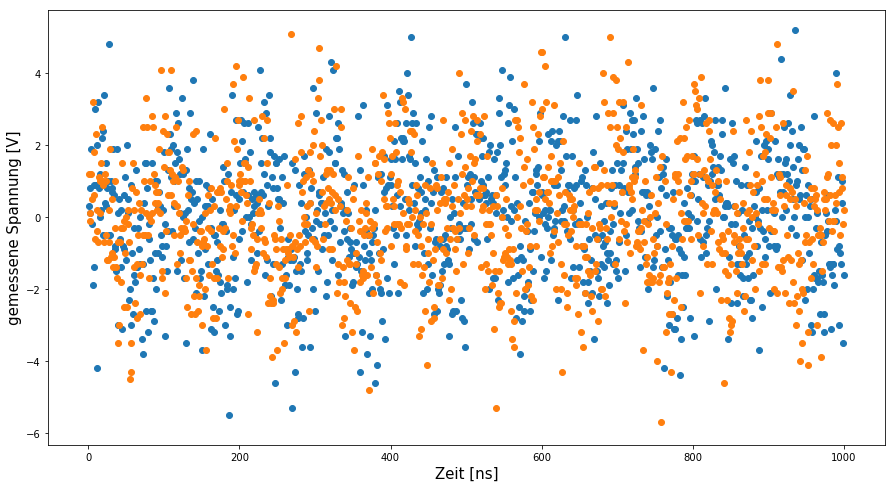

In [24]:
plt.figure(figsize=(15, 8))
plt.scatter(t_mess, U1_mess, marker='o')
plt.scatter(t_mess, U2_mess, marker='o')
#plt.scatter(t_mess, U3_mess, marker='o')
plt.axes().set_aspect('auto', 'datalim')
plt.xlabel('Zeit [ns]', fontsize = 15)
plt.ylabel('gemessene Spannung [V]', fontsize = 15)
plt.show()

## Bestimmung der Kovarianz

In [27]:
C = np.stack((U1_mess,U3_mess), axis=0)
np.cov(C)
np.corrcoef(C)

array([[1.        , 0.43945664],
       [0.43945664, 1.        ]])

In [28]:
# vergleiche Varianzen vor und nach ADC
print(np.var(U1))
print(np.var(U1_mess))

0.7242575412449245
3.0013955100000005


## Bestimmung der Auto-Kovarianz

In [29]:
# definiere Auto-Kovarianzfunktion

def Rxx(x, delta):
    xm = np.mean(x)
    dev_sum = 0
    for i in range(len(x) - delta):
        dev_sum += (x[i] - xm) * (x[i + delta] - xm)
    return dev_sum / (len(x) - delta)

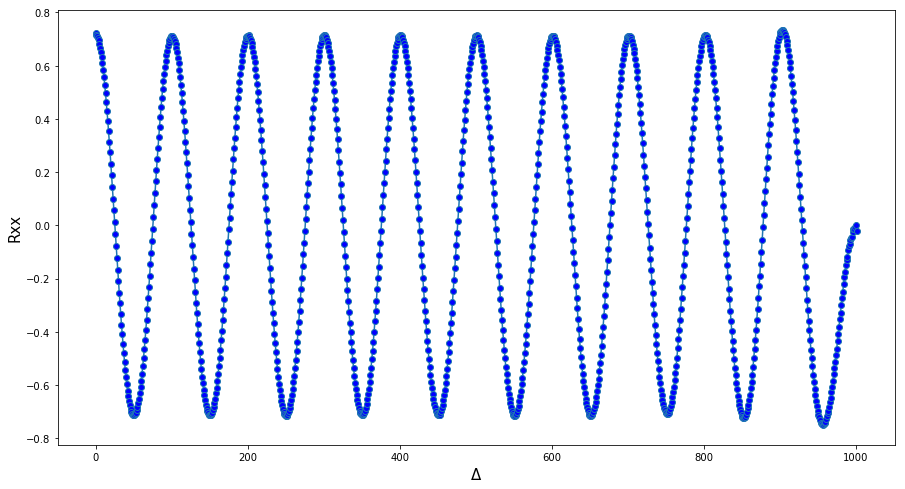

In [30]:
# wende Funktion auf Beispiele an

delta_max = len(U1)

Rxx_vs_delta = [Rxx(U1, i) for i in range(delta_max)]

lags = np.linspace(0, delta_max, num=delta_max)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lags, Rxx_vs_delta, linestyle='-',marker='o',markerfacecolor='blue')
ax.set_xlabel('$\Delta$', fontsize = 15)
ax.set_ylabel('Rxx', fontsize = 15)
plt.show()

## Ultraschneller Laserpuls

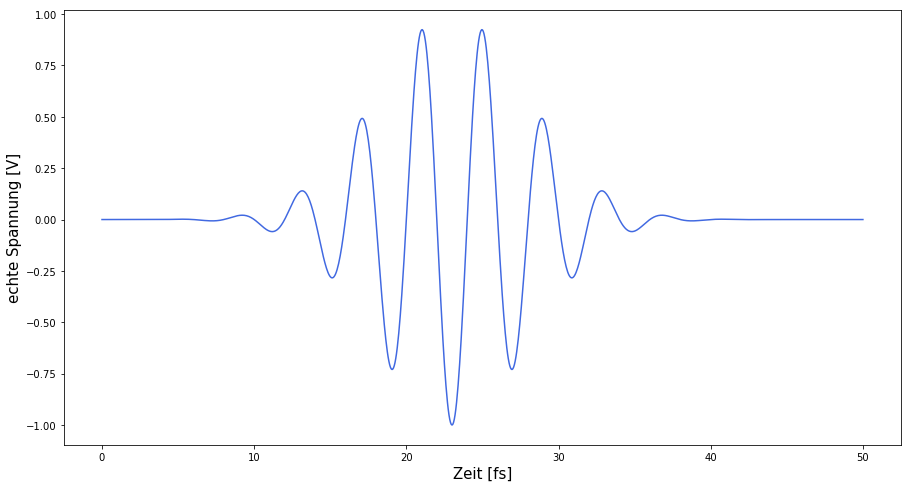

In [31]:
N = 1001 # Länge des Datenvektors
t = np.linspace(0, (N-1)/20, N) # Zeitvektor in Einheit von Femtosekunden (0.000000000000001 s)
# das Verhältnis einer fs zu einer Sekunde entspricht dem Verhältnis einer Sekunde zu 32 Mio Jahren
# t_tot = N fs für unser Beispiel

f_sig = 0.25
Amp = 1
pulse_time = 5
E = Amp*np.sin(2*np.pi*f_sig*t)*np.exp(-0.5*(t-23)**2/pulse_time**2)

plt.figure(figsize=(15, 8))
plt.plot(t, E, color='royalblue', label="E-Feld")
plt.axes().set_aspect('auto', 'datalim')
plt.xlabel('Zeit [fs]', fontsize = 15)
plt.ylabel('echte Spannung [V]', fontsize = 15)
plt.show()

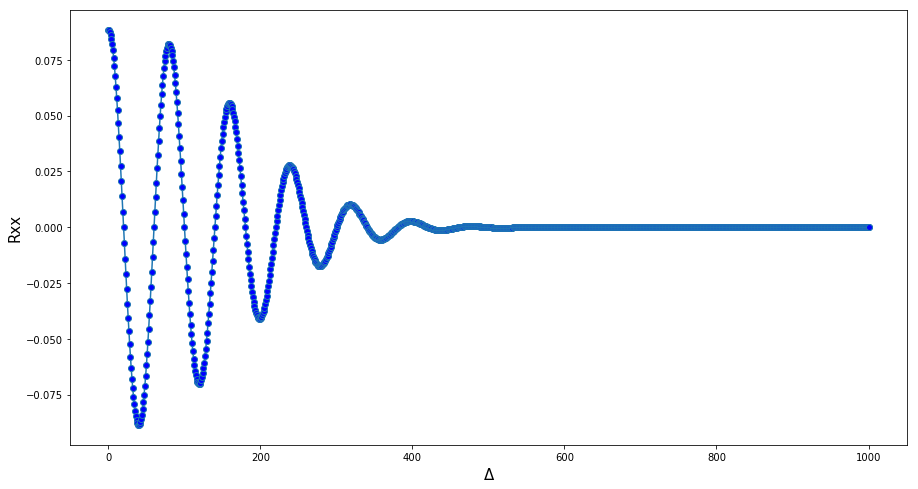

In [32]:
delta_max = len(E)

Rxx_vs_delta = [Rxx(E, i) for i in range(delta_max)]

lags = np.linspace(0, delta_max, num=delta_max)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lags, Rxx_vs_delta, linestyle='-',marker='o',markerfacecolor='blue')
ax.set_xlabel('$\Delta$', fontsize = 15)
ax.set_ylabel('Rxx', fontsize = 15)
plt.show()